# Train scripts for MLP, RNN-CRF, LSTM-CRF and AttentionRNN-CRF

In [5]:
import matplotlib 
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import itertools
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlp_dataset import MWEDataset, readfile
from data_utils import Vocabulary
from mlp_classifier import MLPClassifier
from models import MLP_baseline
import os
from crf import CRF
from lstm_classifier import MweLSTM
from lstm_dataset import LstmDataset
from crf import CRF
import seaborn as sns
import os
from torch.nn.utils.rnn import pad_sequence
np.random.seed(42)

### Corpus stats

In [13]:
#build train vocab
X_toks, Y_tags, toks_vocab, tags_vocab = readfile("corpus/surf.ftb.test", update=True)

In [14]:
dist_tags = Counter(itertools.chain(*Y_tags))

[('O_UNK', 1), ('B_UNK', 1), ('I_UNK', 5), ('O_I', 6), ('O_P+PRO', 9), ('O_ET', 15), ('B_PREF', 23), ('B_C', 25), ('B_PRO', 43), ('I_CL', 45), ('I_PRO', 53), ('O_PREF', 53), ('B_A', 57), ('B_CL', 65), ('B_ET', 80), ('B_P+D', 105), ('I_ET', 126), ('I_V', 158), ('I_C', 200), ('I_P+D', 233), ('B_ADV', 273), ('B_N', 283), ('I_ADV', 294), ('B_D', 619), ('I_A', 825), ('I_D', 870), ('I_P', 988), ('B_P', 996), ('I_PONCT', 997), ('O_PRO', 1245), ('O_CL', 1779), ('I_N', 1903), ('O_P+D', 1922), ('O_C', 2205), ('O_ADV', 2775), ('O_A', 4459), ('O_P', 7836), ('O_V', 7990), ('O_PONCT', 9310), ('O_D', 9708), ('O_N', 16636)]


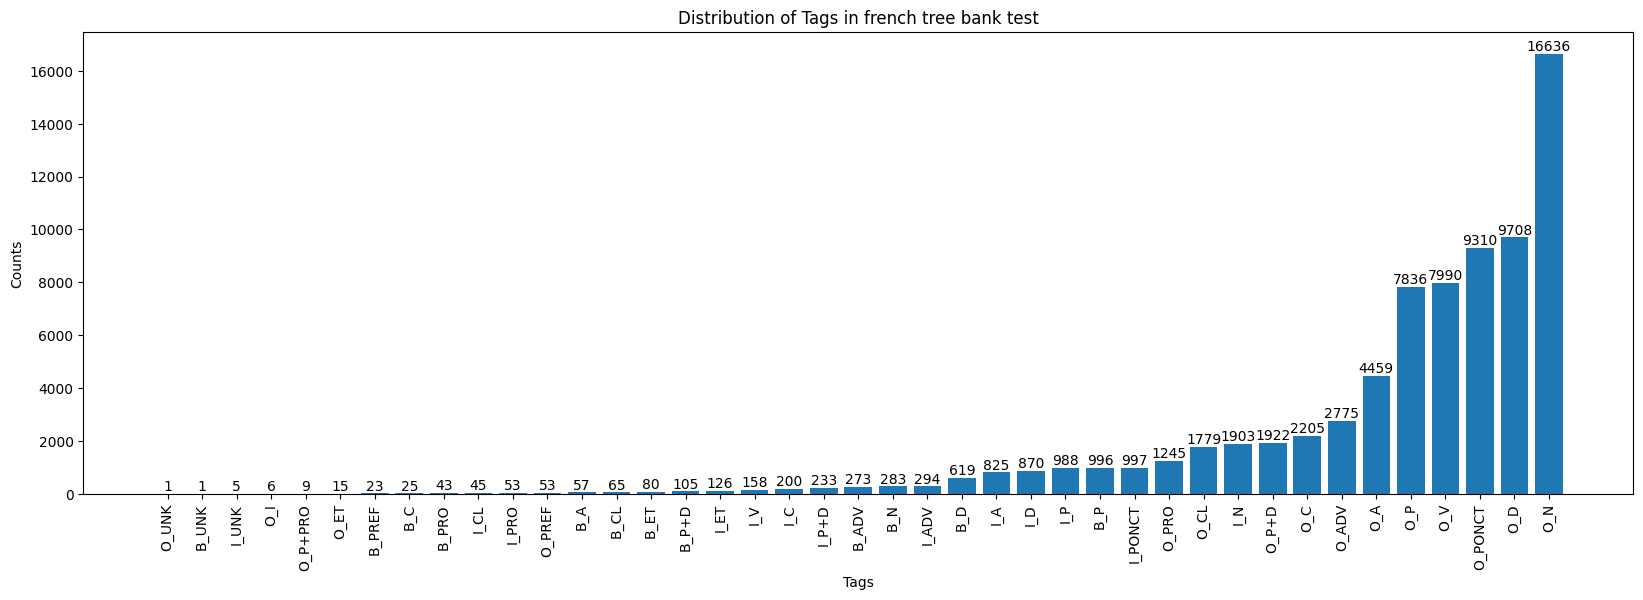

<Figure size 640x480 with 0 Axes>

In [15]:
distribution = [(tag, freq) for tag, freq in dist_tags.items()]
distribution = sorted(distribution, key = lambda x: x[1])
print(distribution)
tags, counts = zip(*distribution)
plt.figure(figsize=(20, 6))
plt.bar(tags, counts)
plt.xticks(rotation=90)
# Display count on every bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Distribution of Tags in french tree bank test')
plt.show()
plt.savefig("test_stats.png")

In [12]:
print(len(toks_vocab))
print(len(tags_vocab))

10050
43


## Train a MLP Model 

You can use the following scripts to train the mlp model, preferably on a GPU machine.

In [4]:
#define the hyperparameters
batch_size    = 16
window_size   =  3 #3 left and 3 right
lr            = 1e-3
device        = "cpu"
epochs        = 5
emb_size      = 200
pretrained    = True
hidden_size   = 128
drop_out      = 0.1

In [16]:
train_dataset = MWEDataset("corpus/surf.ftb.train",  isTrain = True,  window_size = window_size)
testset    = MWEDataset("corpus/surf.ftb.test", window_size = window_size)
devset     = MWEDataset("corpus/surf.ftb.dev", window_size = window_size)
print(len(testset.tags_vocab))

token Vocab size 27472
token Vocab size 27472
48


In [5]:
model = MLPClassifier(
    toks_vocab   = train_dataset.toks_vocab,
    tags_vocab   = train_dataset.tags_vocab, 
    window_size  = window_size,
    emb_size     = emb_size, 
    hidden_size  = hidden_size, 
    drop_out     = drop_out)


In [ ]:
model.train_model(train_dataset,testset, devset, epochs= epochs, lr=lr, batch_size = batch_size, split_train=0.8)

In [ ]:
model.save(".trained_models", "mlp_mod.pth")

### Search for better word embedding params

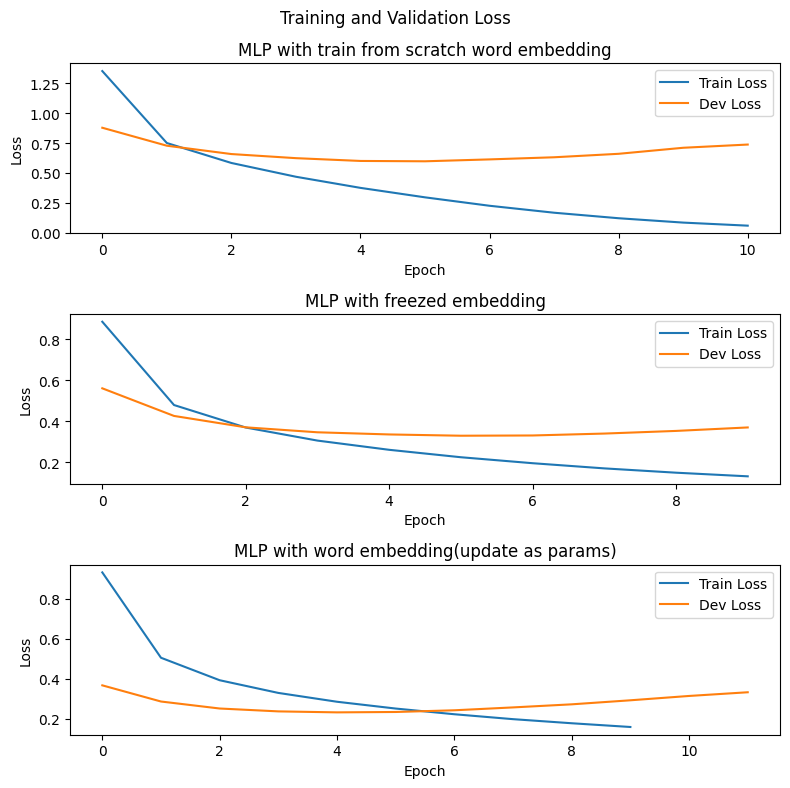

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))

train_loss1 = [1.3516, 0.7504, 0.5837, 0.4685, 0.3756, 0.2965, 0.2261, 0.1680, 0.1219, 0.0855, 0.0599]
dev_loss1 = [0.8780, 0.7279, 0.6582, 0.6239, 0.6006, 0.5977, 0.6135, 0.6313, 0.6603, 0.7107, 0.7376]
train_loss2 = [0.8854, 0.4796, 0.3700, 0.3064, 0.2615, 0.2253, 0.1962, 0.1710, 0.1500, 0.1323]
dev_loss2 = [0.5610, 0.4265, 0.3710, 0.3468, 0.3363, 0.3301, 0.3313, 0.3406, 0.3535, 0.3704]
train_loss3 = [0.9323, 0.5052, 0.3927, 0.3292, 0.2850, 0.2510, 0.2225, 0.1979, 0.1774, 0.1587]
val_loss3 = [0.5975, 0.4621, 0.4039, 0.3738, 0.3541, 0.3460, 0.3418, 0.3411, 0.3424, 0.3478]

axes[0].plot(train_loss1, label='Train Loss')
axes[0].plot(dev_loss1, label='Dev Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MLP with train from scratch word embedding')
axes[0].legend()

axes[1].plot(train_loss2, label='Train Loss')
axes[1].plot(dev_loss2, label='Dev Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('MLP with freezed embedding')
axes[1].legend()

axes[2].plot(train_loss3, label='Train Loss')
axes[2].plot(dev_loss3, label='Dev Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('MLP with word embedding(update as params)')
axes[2].legend()
fig.suptitle("Training and Validation Loss")
plt.tight_layout()

plt.show()

# Train a RNN model

### Vanilla RNN with CRF

In [25]:
#define the hyperparameters
batch_size    = 16
lr            = 1e-3
device        = "cpu"
epochs        = 4
emb_size      = 64
hidden_size   = 64
nb_layers     = 1
drop_out      = 0.1

In [6]:
trainset     = LstmDataset("corpus/surf.ftb.train",  isTrain = True)
testset      = LstmDataset("corpus/surf.ftb.test")
devset       = LstmDataset("corpus/surf.ftb.dev")

token Vocab size 27472
token Vocab size 27472
token Vocab size 27472


In [ ]:
model = MweLSTL(
    name         = "LSTM",
    toks_vocab   = trainset.toks_vocab,
    tags_vocab   = trainset.tags_vocab, 
    emb_size     = emb_size, 
    hidden_size  = hidden_size, 
    drop_out     = drop_out)

In [ ]:
model.train_model(trainset,testset, devset, epochs= epochs, lr=lr, batch_size = batch_size)

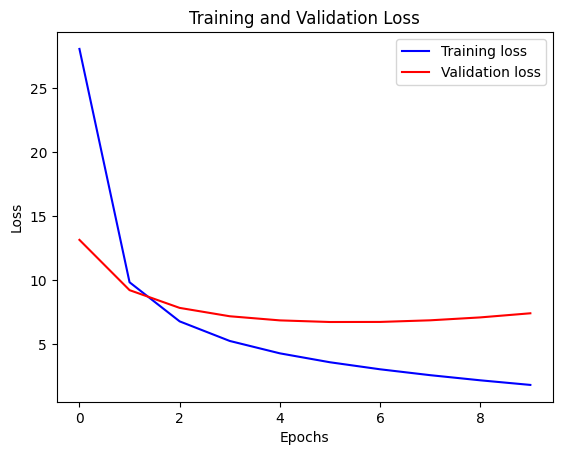

In [3]:
train_losses = [28.0309, 9.8347, 6.7854, 5.2576, 4.2922, 3.5963, 3.0488, 2.5900, 2.1892, 1.8295]
val_losses = [13.1407, 9.2206, 7.8363, 7.1839, 6.8623, 6.7360, 6.7419, 6.8678, 7.0944, 7.4160]
plt.plot(train_losses, 'b', label='Training loss')
plt.plot(val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save(".", "rnn_mod.pth")

# LSTM layer - CRF

In [ ]:
mod_lstm = rnn_classifier.MweRNN(
    name         = "LSTM",
    toks_vocab   = trainset.toks_vocab,
    tags_vocab   = trainset.tags_vocab, 
    emb_size     = emb_size, 
    hidden_size  = hidden_size, 
    drop_out     = 0.)

In [ ]:
mod_lstm.train_model(trainset,testset, devset, epochs= epochs, lr=lr, batch_size = batch_size)

In [ ]:
model.save(".", "lstm_crf_mod.pth")

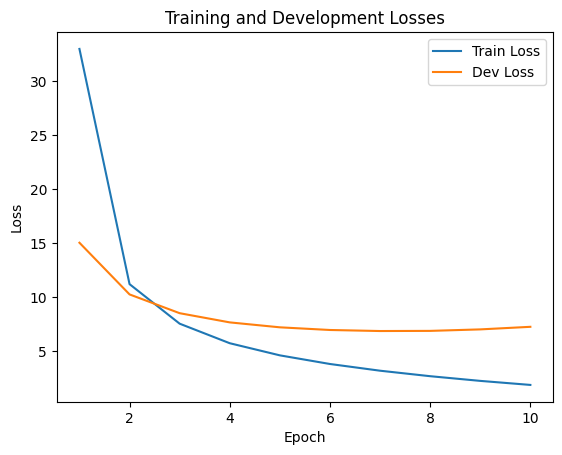

In [4]:
import matplotlib.pyplot as plt

# Define the training and development losses
train_losses = [32.9840, 11.2150, 7.5551, 5.7461, 4.6239, 3.8242, 3.2030, 2.6946, 2.2609, 1.8872]
dev_losses = [15.0466, 10.2638, 8.5258, 7.6746, 7.2184, 6.9711, 6.8748, 6.8885, 7.0264, 7.2649]

# Create a list of epochs
epochs = range(1, len(train_losses) + 1)

# Plot the training and development losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Dev Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Development Losses')
plt.legend()

# Display the plot
plt.show()